# Guided Project: Task 2A: Image-Caption Retrieval with CLIP

This notebook implements image-to-caption retrieval using CLIP (Contrastive Language-Image Pretraining).

## Names
1. Diego Bermudez Sierra - dabermud@andrew.cmu.edu
2. Santiago Bolaños Vega - sbolaosv@andrew.cmu.edu

## Objectives:
1. Load pretrained CLIP model from Hugging Face
2. Compute embeddings for images and captions
3. Perform image-to-caption retrieval using cosine similarity
4. Evaluate retrieval performance with multiple metrics:
   - Recall@K (instance-level and class-aware)
   - BERTScore
   - CLIPScore
   - Mean Average Precision (MAP)

## AI Acknowledgement
This task was completed with assistance from an AI coding assistant (Auto, powered by Cursor) that helped implement and debug the code for Task 2A: Image-Caption Retrieval with CLIP. The assistant provided guidance on environment setup, resolved PyTorch CUDA compatibility issues, fixed CLIP model loading with safetensors support, corrected data loading functions to properly parse the captions.txt file format, and helped configure the GPU environment on Bridges2. All code implementations, debugging, and final solutions were developed collaboratively through iterative problem-solving sessions.

In [5]:
config = {
    'root_eeg': "/jet/home/bermudez/exploring-eeg/4-eeg-classifiers",
    'root_clip': "/jet/home/bermudez/exploring-eeg/5-caption-retrieval",
    'project_root': "/jet/home/bermudez/exploring-eeg",

    'eeg_results_path': "/results/Conformer_Finetune_Multihead",

    'data_root': "/ocean/projects/cis250019p/gandotra/11785-gp-eeg",
    'model_name': "openai/clip-vit-base-patch32",
    
    'epochs': 20,
    'batch_size': 256,

    'lora_rank': 64,
    'lora_alpha': 16,

    'temperature': 0.05,
    
    'lr': 5e-5,
    'weight_decay': 5e-4
}

# Imports

In [6]:
import os
import sys
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPModel, CLIPProcessor

import matplotlib.pyplot as plt

sys.path.append(config['root_eeg'])

# Path to this folder (CLIP utilities live in utils_clip/)
sys.path.append(config['root_clip'])


from data_extraction.dataset_builder import build_trial_index, split_by_session

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

PROJECT_ROOT = Path(config['project_root'])

EEG_DIR      = Path(config['root_eeg'])
CAPTION_DIR  = Path(config['root_clip'])

DATA_ROOT = Path(config['data_root'])
CAPTIONS_PATH = DATA_ROOT / "captions.txt"

EEG_RESULTS_DIR = Path(config['root_eeg']+config['eeg_results_path'])
print("EEG results dir:", EEG_RESULTS_DIR)

Using device: cuda
EEG results dir: /jet/home/bermudez/exploring-eeg/4-eeg-classifiers/results/Conformer_Finetune_Multihead


# Load CLIP Model

In [7]:
# %%
model_name = config['model_name']
print(f"Loading CLIP model: {model_name}")

clip_model = CLIPModel.from_pretrained(model_name, use_safetensors=True).to(device)
clip_processor = CLIPProcessor.from_pretrained(model_name)

clip_model.eval()
for p in clip_model.parameters():
    p.requires_grad = False  # we'll only train our own adapter + EEG head

text_embed_dim = clip_model.config.projection_dim
print("Text embedding dim:", text_embed_dim)

Loading CLIP model: openai/clip-vit-base-patch32
Text embedding dim: 512


# Load EEG embedings

In [8]:
# %%
def load_eeg_split(split: str, base_dir: Path):
    """
    Load EEG features and metadata for a given split: 'train', 'val', 'test'.
    """
    feats_path = base_dir / f"multihead_{split}_embeddings.npy"
    meta_path  = base_dir / f"multihead_{split}_meta.csv"

    assert feats_path.exists(), f"Missing {feats_path}"
    assert meta_path.exists(),  f"Missing {meta_path}"

    feats = np.load(feats_path)          # [N, hidden_dim]
    meta  = pd.read_csv(meta_path)       # columns: subject, session, run, image_name, class_id

    print(f"{split}: features {feats.shape}, meta {meta.shape}")
    return feats, meta

eeg_train_feats, eeg_train_meta = load_eeg_split("train", EEG_RESULTS_DIR)
eeg_val_feats,   eeg_val_meta   = load_eeg_split("val",   EEG_RESULTS_DIR)
eeg_test_feats,  eeg_test_meta  = load_eeg_split("test",  EEG_RESULTS_DIR)

eeg_feat_dim = eeg_train_feats.shape[1]
print("EEG feature dim:", eeg_feat_dim)

train: features (15600, 384), meta (15600, 6)
val: features (5200, 384), meta (5200, 6)
test: features (5200, 384), meta (5200, 6)
EEG feature dim: 384


In [9]:
# %%
index_df = build_trial_index(DATA_ROOT, CAPTIONS_PATH)
index_df = split_by_session(index_df)

print("Index df columns:", index_df.columns.tolist())
print("Index df head:")
print(index_df.head())

Found 519 EEG run files under /ocean/projects/cis250019p/gandotra/11785-gp-eeg
Indexed 26000 EEG trials from 519 runs.
Loaded 9825 caption entries from captions.txt
Merged 9825 labels from captions.txt.
Filtered labeled EEG trials: 26000/26000 remain (100.0%)
Split summary:
split
train    15600
test      5200
val       5200
Name: count, dtype: int64
Index df columns: ['subject', 'session', 'run', 'trial', 'eeg_path', 'csv_path', 'image_name', 'image_key', 'category', 'class_id', 'abstracted', 'split']
Index df head:
  subject session     run  trial  \
0  sub-02  ses-01  run-01      0   
1  sub-02  ses-01  run-01      1   
2  sub-02  ses-01  run-01      2   
3  sub-02  ses-01  run-01      3   
4  sub-02  ses-01  run-01      4   

                                            eeg_path  \
0  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
1  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
2  /ocean/projects/cis250019p/gandotra/11785-gp-e...   
3  /ocean/projects/cis250019p/gandotr

In [10]:
# %%
# Select only the fields we need from index_df to avoid duplication
index_key_cols = [
    "subject", "session", "run", "image_name",
    "category", "class_id", "abstracted"
]

index_small = index_df[index_key_cols].drop_duplicates()
print("Condensed index shape:", index_small.shape)

def attach_captions(eeg_meta: pd.DataFrame, index_small: pd.DataFrame) -> pd.DataFrame:
    """
    Merge EEG meta with index_small to add 'category' and 'abstracted' (caption).
    """
    merged = eeg_meta.merge(
        index_small,
        on=["subject", "session", "run", "image_name", "class_id"],
        how="left",
        validate="m:1"
    )
    missing = merged["abstracted"].isna().sum()
    if missing > 0:
        print(f"Warning: {missing} trials could not be matched to captions.")
    return merged

eeg_train_meta_full = attach_captions(eeg_train_meta, index_small)
eeg_val_meta_full   = attach_captions(eeg_val_meta, index_small)
eeg_test_meta_full  = attach_captions(eeg_test_meta, index_small)

print("Train meta with captions:", eeg_train_meta_full.head())

Condensed index shape: (26000, 7)
Train meta with captions:   subject session     run                                         image_name  \
0  sub-24  ses-01  run-04  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
1  sub-03  ses-04  run-02  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
2  sub-05  ses-01  run-04  C:\Users\Huawei\Desktop\eeg_pascal_imagenet\pi...   
3  sub-15  ses-05  run-03  C:\Users\casia\Desktop\eeg_code_exp-info\pic_1...   
4  sub-05  ses-05  run-01  C:\Users\DELL\Desktop\eeg_code_exp-info\pic_10...   

  category_x  class_id category_y  \
0  aeroplane         0  aeroplane   
1      chair         8      chair   
2      train        18      train   
3     flower        12     flower   
4    bicycle         1    bicycle   

                                       abstracted  
0       Aeroplane taking off from a grassy runway  
1             Red chair sitting on a wooden porch  
2  Green train passing alongside a white building  
3         Pink flower bloomi

# Dataset

In [11]:
# %%
class EEGCaptionDataset(Dataset):
    """
    Simple dataset: EEG feature vector + caption text.
    """
    def __init__(self, features: np.ndarray, meta_df: pd.DataFrame):
        assert len(features) == len(meta_df)
        self.features = torch.from_numpy(features).float()
        self.meta_df  = meta_df.reset_index(drop=True)

        if "abstracted" not in self.meta_df.columns:
            raise ValueError("meta_df must contain 'abstracted' column with caption text.")

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx: int):
        eeg_feat = self.features[idx]            # [eeg_dim]
        row = self.meta_df.iloc[idx]
        caption = row["abstracted"]
        class_id = int(row["class_id"])
        return eeg_feat, caption, class_id

train_ds = EEGCaptionDataset(eeg_train_feats, eeg_train_meta_full)
val_ds   = EEGCaptionDataset(eeg_val_feats,   eeg_val_meta_full)
test_ds  = EEGCaptionDataset(eeg_test_feats,  eeg_test_meta_full)

print("Sizes — train:", len(train_ds), "val:", len(val_ds), "test:", len(test_ds))

Sizes — train: 15600 val: 5200 test: 5200


# Dataloader

In [12]:
BATCH_SIZE = config['batch_size']

def collate_eeg_caption(batch):
    """
    Collate function:
        batch: list of (eeg_feat, caption, class_id)
    """
    eeg_feats, captions, class_ids = zip(*batch)
    eeg_tensor = torch.stack(eeg_feats, dim=0)      # [B, eeg_dim]
    class_ids  = torch.tensor(class_ids, dtype=torch.long)
    return eeg_tensor, list(captions), class_ids

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_eeg_caption,
    pin_memory=True
)

eeg_batch, cap_batch, cls_batch = next(iter(train_loader))
print("EEG batch:", eeg_batch.shape)
print("Example caption:", cap_batch[0])

EEG batch: torch.Size([256, 384])
Example caption: Metal frame sofa with mattress on wooden floor


# Model Definition

In [13]:
# %%
class LoRAAdapter(nn.Module):
    """
    Simple LoRA-style adapter on top of CLIP text embeddings:
    out = x + B(A(x)), where A: d->r, B: r->d with r << d.
    """
    def __init__(self, dim: int, rank: int = 32, alpha: float = 1.0):
        super().__init__()
        self.dim = dim
        self.rank = rank
        self.alpha = alpha

        self.A = nn.Linear(dim, rank, bias=False)
        self.B = nn.Linear(rank, dim, bias=False)

        # Initialize A small, B zero (so initial output is approx x)
        nn.init.kaiming_uniform_(self.A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.B.weight)

    def forward(self, x):
        # x: [B, d]
        delta = self.B(self.A(x)) * (self.alpha / self.rank)
        return x + delta


import math

class EEGToCLIPModel(nn.Module):
    """
    EEG → CLIP text space model with:
      - Frozen CLIP text encoder
      - LoRAAdapter on top of text embeddings
      - Projection head: EEG features -> CLIP text embedding dim
      - Contrastive (InfoNCE) loss between EEG embeddings and adapted text embeddings
    """
    def __init__(self, clip_model: CLIPModel, eeg_feat_dim: int, lora_rank: int = 32, temperature: float = 0.07, alpha: float = 1.0):
        super().__init__()
        self.clip_model = clip_model
        self.text_dim = clip_model.config.projection_dim
        self.temperature = temperature

        # EEG projection: small MLP
        self.eeg_proj = nn.Sequential(
            nn.Linear(eeg_feat_dim, 512),
            nn.GELU(),
            nn.Linear(512, self.text_dim)
        )

        # LoRA adapter on text embeddings
        self.text_lora = LoRAAdapter(self.text_dim, rank=lora_rank, alpha=alpha)

    def encode_text(self, captions, device):
        """
        captions: list[str]
        Returns: normalized text embeddings after LoRA adapter, shape [B, d]
        """
        inputs = clip_processor(
            text=captions,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        with torch.no_grad():
            text_feats = self.clip_model.get_text_features(**inputs)  # [B, d]
        text_feats = F.normalize(text_feats, dim=-1)

        # Apply LoRA adapter (trainable)
        text_feats = self.text_lora(text_feats)
        text_feats = F.normalize(text_feats, dim=-1)
        return text_feats

    def encode_eeg(self, eeg_feats):
        """
        eeg_feats: [B, eeg_feat_dim]
        Returns: normalized EEG embeddings [B, d]
        """
        z = self.eeg_proj(eeg_feats)
        z = F.normalize(z, dim=-1)
        return z

    def forward(self, eeg_feats, captions, device):
        """
        Compute InfoNCE loss between EEG embeddings and text embeddings.
        """
        z_eeg = self.encode_eeg(eeg_feats)                # [B, d]
        z_txt = self.encode_text(captions, device)        # [B, d]

        # Similarity matrix [B, B]
        logits = (z_eeg @ z_txt.T) / self.temperature

        # Targets are diagonals (i matches i)
        targets = torch.arange(z_eeg.size(0), device=device)

        loss_i2t = F.cross_entropy(logits, targets)
        loss_t2i = F.cross_entropy(logits.T, targets)

        loss = 0.5 * (loss_i2t + loss_t2i)

        return loss, z_eeg.detach(), z_txt.detach()

# Setup Model

In [14]:
# %%
model_eeg_clip = EEGToCLIPModel(
    clip_model=clip_model,
    eeg_feat_dim=eeg_feat_dim,
    lora_rank=config['lora_rank'],
    temperature=config['temperature'],
    alpha=config['lora_alpha']
).to(device)

print("Trainable params:",
      sum(p.numel() for p in model_eeg_clip.parameters() if p.requires_grad))

optimizer = torch.optim.AdamW(
    model_eeg_clip.parameters(),
    lr=config['lr'],
    weight_decay=config['weight_decay'],
    betas=(0.9, 0.999),
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=config['epochs'],    # you can tune this
    eta_min=1e-6
)

Trainable params: 525312


# Training

In [15]:
# %%
from copy import deepcopy

NUM_EPOCHS = config['epochs']
best_val_loss = float("inf")
best_state_dict = None

for epoch in range(1, NUM_EPOCHS + 1):
    # ---- Train ----
    model_eeg_clip.train()
    train_loss, train_count = 0.0, 0

    for eeg_feats, captions, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [train]"):
        eeg_feats = eeg_feats.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        loss, _, _ = model_eeg_clip(eeg_feats, captions, device)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_eeg_clip.parameters(), 1.0)
        optimizer.step()

        bs = eeg_feats.size(0)
        train_loss += loss.item() * bs
        train_count += bs

    train_loss /= max(1, train_count)

    # ---- Validation ----
    model_eeg_clip.eval()
    val_loss, val_count = 0.0, 0

    with torch.no_grad():
        for eeg_feats, captions, _ in tqdm(val_loader, desc=f"Epoch {epoch}/{NUM_EPOCHS} [val]"):
            eeg_feats = eeg_feats.to(device, non_blocking=True)
            loss, _, _ = model_eeg_clip(eeg_feats, captions, device)
            bs = eeg_feats.size(0)
            val_loss += loss.item() * bs
            val_count += bs

    val_loss /= max(1, val_count)

    # Scheduler
    scheduler.step()

    print(f"Epoch {epoch:02d} | train loss={train_loss:.4f} | val loss={val_loss:.4f}")

    # Save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state_dict = deepcopy(model_eeg_clip.state_dict())
        print(f"New best model (val loss={val_loss:.4f})")

# Load best
if best_state_dict is not None:
    model_eeg_clip.load_state_dict(best_state_dict)
    print(f"\nLoaded best model with val loss={best_val_loss:.4f}")

Epoch 1/20 [val]:   0%|                                                                                                                                                                                     | 0/21 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 01 | train loss=5.3323 | val loss=5.7147
New best model (val loss=5.7147)


Epoch 2/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 02 | train loss=5.2432 | val loss=5.7280


Epoch 3/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 03 | train loss=5.2281 | val loss=5.7396


Epoch 4/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 04 | train loss=5.2194 | val loss=5.7381


Epoch 5/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 05 | train loss=5.2144 | val loss=5.7456


Epoch 6/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 06 | train loss=5.2082 | val loss=5.7587


Epoch 7/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 07 | train loss=5.2045 | val loss=5.7541


Epoch 8/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 08 | train loss=5.2005 | val loss=5.7569


Epoch 9/20 [train]:   0%|                                                                                                                                                                                   | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 09 | train loss=5.1982 | val loss=5.7519


Epoch 10/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 10 | train loss=5.1945 | val loss=5.7580


Epoch 11/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 11 | train loss=5.1922 | val loss=5.7605


Epoch 12/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 12 | train loss=5.1908 | val loss=5.7637


Epoch 13/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 13 | train loss=5.1878 | val loss=5.7655


Epoch 14/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 14 | train loss=5.1860 | val loss=5.7707


Epoch 15/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 15 | train loss=5.1856 | val loss=5.7652


Epoch 16/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 16 | train loss=5.1838 | val loss=5.7629


Epoch 17/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 17 | train loss=5.1831 | val loss=5.7651


Epoch 18/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 18 | train loss=5.1822 | val loss=5.7653


Epoch 19/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 19 | train loss=5.1816 | val loss=5.7656


Epoch 20/20 [train]:   0%|                                                                                                                                                                                  | 0/61 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

Epoch 20 | train loss=5.1808 | val loss=5.7654

Loaded best model with val loss=5.7147


## Embedding Bank

In [16]:
# %%
# Build a bank of unique captions from EEG trials (train+val+test)
all_meta = pd.concat(
    [eeg_train_meta_full, eeg_val_meta_full, eeg_test_meta_full],
    axis=0,
    ignore_index=True
)

# Use the caption text
all_captions = all_meta["abstracted"].tolist()
print("Total EEG-caption pairs:", len(all_captions))

# Optionally deduplicate captions (many will repeat)
unique_captions = sorted(set(all_captions))
print("Unique captions:", len(unique_captions))

# Map caption -> index
caption2idx = {c: i for i, c in enumerate(unique_captions)}

# Precompute caption indices for each trial
all_meta["caption_idx"] = [caption2idx[c] for c in all_meta["abstracted"]]

# Compute text embedding bank for unique captions (with LoRA adapter)
BATCH = 64
text_emb_bank = []

model_eeg_clip.eval()
with torch.no_grad():
    for i in tqdm(range(0, len(unique_captions), BATCH), desc="Computing caption embedding bank"):
        batch_caps = unique_captions[i:i+BATCH]
        z_txt = model_eeg_clip.encode_text(batch_caps, device)    # [b, d]
        text_emb_bank.append(z_txt.cpu())

text_emb_bank = torch.cat(text_emb_bank, dim=0)   # [N_caps, d]
print("Caption embedding bank:", text_emb_bank.shape)

Total EEG-caption pairs: 26000
Unique captions: 8331


Computing caption embedding bank: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 131/131 [00:01<00:00, 99.31it/s]

Caption embedding bank: torch.Size([8331, 512])


# Evaluation

In [17]:
# %%
# Compute EEG embeddings on test set
model_eeg_clip.eval()
eeg_emb_list = []
caption_idx_list = []

with torch.no_grad():
    for eeg_feats, captions, _ in tqdm(test_loader, desc="Encoding EEG test set"):
        eeg_feats = eeg_feats.to(device, non_blocking=True)
        z_eeg = model_eeg_clip.encode_eeg(eeg_feats)  # [B, d]
        eeg_emb_list.append(z_eeg.cpu())

        # Map captions -> caption_idx via caption2idx
        for c in captions:
            caption_idx_list.append(caption2idx[c])

eeg_emb_test = torch.cat(eeg_emb_list, dim=0)               # [N_test, d]
caption_idx_test = np.array(caption_idx_list, dtype=np.int64)
print("EEG test embeddings:", eeg_emb_test.shape)
print("Caption idx test:", caption_idx_test.shape)

Encoding EEG test set:   0%|                                                                                                                                                                                | 0/21 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism t

EEG test embeddings: torch.Size([5200, 512])
Caption idx test: (5200,)


In [18]:
# %%
def eeg_to_caption_retrieval(eeg_emb, text_bank, k=5):
    """
    eeg_emb: [N, d]
    text_bank: [M, d]
    returns:
        retrieved_indices: [N, k]
    """
    # [N, M]
    sims = eeg_emb @ text_bank.T
    top_k_scores, top_k_idx = torch.topk(sims, k=k, dim=1)
    return top_k_idx.numpy(), top_k_scores.numpy()

K_VALUES = [1, 3, 5]

retrieved_idx, retrieved_scores = eeg_to_caption_retrieval(
    eeg_emb_test, text_emb_bank, k=max(K_VALUES)
)

def compute_recall_at_k_eeg(retrieved_idx, true_idx, k_values):
    N = len(true_idx)
    recalls = {}
    for k in k_values:
        topk = retrieved_idx[:, :k]
        hits = 0
        for i in range(N):
            if true_idx[i] in topk[i]:
                hits += 1
        recalls[f"Recall@{k}"] = hits / N
    return recalls

recall_eeg = compute_recall_at_k_eeg(retrieved_idx, caption_idx_test, K_VALUES)

print("EEG → Caption Retrieval:")
for k, v in recall_eeg.items():
    print(f"  {k}: {v:.4f}")

EEG → Caption Retrieval:
  Recall@1: 0.0000
  Recall@3: 0.0002
  Recall@5: 0.0004


Computing CLIPScore distributions for EEG → Caption...
Matched CLIPScore: mean=0.0272, std=0.0463
Mismatched CLIPScore: mean=0.0208, std=0.0474


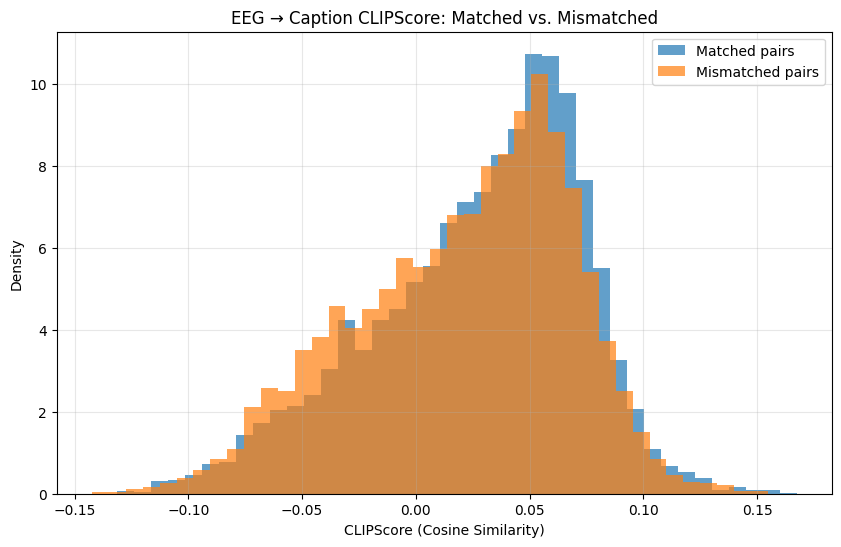

In [19]:


# %%
print("Computing CLIPScore distributions for EEG → Caption...")

eeg_emb = eeg_emb_test        # [N_test, d]
txt_bank = text_emb_bank      # [N_caps, d]
true_cap_idx = caption_idx_test  # [N_test]

N = eeg_emb.size(0)

matched_scores = []
mismatched_scores = []

# --- Matched EEG↔Caption similarity ---
for i in range(N):
    eeg_vec = eeg_emb[i : i+1]                           # [1, d]
    cap_idx = true_cap_idx[i]
    txt_vec = txt_bank[cap_idx : cap_idx+1]             # [1, d]
    sim = torch.matmul(eeg_vec, txt_vec.T).item()
    matched_scores.append(sim)

# --- Mismatched EEG↔Random Caption similarity ---
rng = np.random.default_rng()
for i in range(N):
    eeg_vec = eeg_emb[i : i+1]
    
    # Select random caption not equal to true one
    cap_idx = true_cap_idx[i]
    choices = [j for j in range(len(txt_bank)) if j != cap_idx]
    neg_idx = rng.choice(choices)
    
    txt_vec = txt_bank[neg_idx : neg_idx+1]
    sim = torch.matmul(eeg_vec, txt_vec.T).item()
    mismatched_scores.append(sim)

matched_scores  = np.array(matched_scores)
mismatched_scores = np.array(mismatched_scores)

print(f"Matched CLIPScore: mean={matched_scores.mean():.4f}, std={matched_scores.std():.4f}")
print(f"Mismatched CLIPScore: mean={mismatched_scores.mean():.4f}, std={mismatched_scores.std():.4f}")

# --- Plot ---
plt.figure(figsize=(10,6))
plt.hist(matched_scores, bins=40, alpha=0.7, label='Matched pairs', density=True)
plt.hist(mismatched_scores, bins=40, alpha=0.7, label='Mismatched pairs', density=True)
plt.xlabel("CLIPScore (Cosine Similarity)")
plt.ylabel("Density")
plt.title("EEG → Caption CLIPScore: Matched vs. Mismatched")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [20]:
# %% [markdown]
# ## EEG → Caption Retrieval: Visualization Examples (Optional)

# %%
def visualize_eeg_caption_retrieval(
    eeg_emb,
    text_emb_bank,
    meta_df,
    unique_captions,
    k=3,
    num_examples=5
):
    """
    Visualize EEG→Caption retrieval examples.
    Shows:
        - Ground truth caption
        - Top-k retrieved captions
        - CLIPScore
    """
    N = len(eeg_emb)
    step = max(1, N // num_examples)

    for i in range(0, N, step):
        if num_examples <= 0:
            break
        num_examples -= 1

        eeg_vec = eeg_emb[i : i+1]    # [1, d]
        sims = (eeg_vec @ text_emb_bank.T).squeeze(0)  # [N_caps]
        top_scores, top_idx = torch.topk(sims, k=k)

        gt_caption = meta_df.iloc[i]["abstracted"]

        print("=" * 70)
        print(f"Example #{i}")
        print(f"**Ground truth caption:** {gt_caption}\n")

        for rank in range(k):
            cap = unique_captions[top_idx[rank]]
            score = top_scores[rank].item()
            is_correct = (cap == gt_caption)

            color = "\033[92m" if is_correct else "\033[91m"
            reset = "\033[0m"

            print(f"{color}Top-{rank+1}: {cap}  (Sim={score:.4f}){reset}")

        print()

# Run visualization
visualize_eeg_caption_retrieval(
    eeg_emb_test,
    text_emb_bank,
    all_meta.iloc[len(eeg_train_meta_full) + len(eeg_val_meta_full):],  # test rows only
    unique_captions,
    k=3,
    num_examples=5
)

Example #0
**Ground truth caption:** Wooden diningtable with matching chairs on hardwood floor

Top-1: Dog meeting other animals on gravel ground  (Sim=0.1378)
Top-2: Dog jumping on grassy field near trees  (Sim=0.1298)
Top-3: Horse with blonde mane near a building  (Sim=0.1276)

Example #1040
**Ground truth caption:** Blue car parked on asphalt near mountains

Top-1: Blue glass bottle with engraved Toronto text  (Sim=0.1256)
Top-2: Glass bottle rows glowing with neon drinks  (Sim=0.1253)
Top-3: Coca-Cola glass bottle with vintage carton pack  (Sim=0.1240)

Example #2080
**Ground truth caption:** Blue sofa with two black cushions nearby table

Top-1: Cat sitting by a tree on gravel  (Sim=0.1812)
Top-2: Smiling cat sitting on a blue bed  (Sim=0.1699)
Top-3: Cat with fluffy fur near colorful fabrics  (Sim=0.1670)

Example #3120
**Ground truth caption:** Cow grazing on a grassy open field

Top-1: Cat sitting by a tree on gravel  (Sim=0.1704)
Top-2: Black and white dog standing on gravel  